In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
plt.rcParams.update({'font.size': 15})

In [3]:
run /home/lmberkhout/src/pychfpga/pychfpga/sifpga_crs_corr_capture.py --verbose=False

Enabling nested event loop on current loop ID 132553068650256
Adding new log handlers of <Logger pychfpga (WARNING)> with level debug
Opened TCPipe socket at ('10.10.10.33', 34630)


There are no IceCrates in the hardware map!


+--------------+-----------------+
| Standalone   | Virt. slot None |
| Motherboards | CRS_SN0032      |
|              | 10.10.10.106    |
+--------------+-----------------+
| Mezz1        | -               |
| Mezz2        | -               |
+--------------+-----------------+

Forcing output 0 mode to LVPECL because fout is high
Forcing output 8 mode to LVPECL because fout is high
Forcing output 9 mode to LVPECL because fout is high
Forcing output 10 mode to LVPECL because fout is high
Forcing output 11 mode to LVPECL because fout is high
Forcing output 12 mode to LVPECL because fout is high
TCPipe: Programming FPGA with 34437356 bytes


chFPGA(None, 'CRS_SN0032'): Sync is not yet implemented on the CRS
chFPGA(None, 'CRS_SN0032'): Sync is not yet implemented on the CRS
chFPGA(None, 'CRS_SN0032'): There is no 1st CROSSBAR module in this firmware build (so there can't be data streamed to the correlators or GPU links!)
chFPGA(None, 'CRS_SN0032'): There is no 2nd CROSSBAR module in this firmware build
chFPGA(None, 'CRS_SN0032'): There is no 3rd CROSSBAR module in this firmware build
{self!r}: Cannot set data width on UltraCT. Command is ignored. 
{self!r}: set_frames_per_packet is not implemented on UltraCT. Packet size is set through the playlist. Command is ignored. 
The platform does not support SYNC sources
chFPGA(None, 'CRS_SN0032'): Sync is not yet implemented on the CRS
chFPGA(None, 'CRS_SN0032'): Sync is not yet implemented on the CRS
FPGAArray(1_boards,0_crates): SYNC will not be checked as not all firmware have SYNC logic
chFPGA(None, 'CRS_SN0032'): Sync is not yet implemented on the CRS


-------------- CHAN[0].FFT STATUS --------------
 FFT Bypass: False
 FFT SHIFT schedule: 0x3FFF
 CASPER block pipeling delay: Measured=12533, set point=12533:  clocks
 Number of FFT overflows: 0
None
-------------- CHAN[1].FFT STATUS --------------
 FFT Bypass: False
 FFT SHIFT schedule: 0x3FFF
 CASPER block pipeling delay: Measured=12533, set point=12533:  clocks
 Number of FFT overflows: 0
None
-------------- CHAN[2].FFT STATUS --------------
 FFT Bypass: False
 FFT SHIFT schedule: 0x3FFF
 CASPER block pipeling delay: Measured=12533, set point=12533:  clocks
 Number of FFT overflows: 0
None
-------------- CHAN[3].FFT STATUS --------------
 FFT Bypass: False
 FFT SHIFT schedule: 0x3FFF
 CASPER block pipeling delay: Measured=12533, set point=12533:  clocks
 Number of FFT overflows: 0
None
-------------- CHAN[4].FFT STATUS --------------
 FFT Bypass: False
 FFT SHIFT schedule: 0x3FFF
 CASPER block pipeling delay: Measured=12533, set point=12533:  clocks
 Number of FFT overflows: 0
None


In [4]:
s_per_frame = 2**14*(1/(ccc.fs*1e6)) # samples/frame * seconds/sample. Make sure sampling frequency is in Hz
board_inputs = ['W6Y', 'W6X', 'E6Y', 'E6X', 'M6Y', 'M6X', 'Antenna1', 'Antenna 2'] 

# Long FFT Measurements

In [24]:
for n in range(ccc.NPOLS):
    # Configure each FFT
    fft = ccc.i.chan[n].FFT
    # fft.FFT_SHIFT = 0b11111111111000
    fft.FFT_SHIFT = 0b00011111111111 # reverse the order

In [25]:
n_fft_integrations = 100 # 30
n_fft_captures = 10
fft_integration_period = 2*n_fft_captures*s_per_frame # we capture two contiguous frames at a time, so we recover twice as many frames as captures
print(fft_integration_period)

0.0001024


In [26]:
%%capture

psd_fft = np.zeros((n_fft_integrations, ccc.NPOLS, len(ccc.f)))
kert_fft = np.zeros((n_fft_integrations, ccc.NPOLS, len(ccc.f)))
fft_cap_adc_ovflws = np.zeros((n_fft_integrations, ccc.NPOLS))
# fft_cap_adc_rms_power_dBm = np.zeros((n_adc_integrations, ccc.NPOLS))
fft_cap_fft_ovflws = np.zeros((n_fft_integrations, ccc.NPOLS))

for n in range(n_fft_integrations):
    print(f'{n}/{n_fft_integrations}')
    
    # Pulse the overflows resets
    for m in range(ccc.NPOLS):

        # Reset ADC stats capture (which is actually in the Scaler module)
        ccc.i.chan[m].SCALER.STATS_FRAME_COUNT = n_fft_captures
        ccc.i.chan[m].SCALER.STATS_CAPTURE = 0 # capture new stats
        # print(m, ccc.i.chan[m].SCALER.STATS_CAPTURE)
        ccc.i.chan[m].SCALER.STATS_CAPTURE = 1
        # print(m, ccc.i.chan[m].SCALER.STATS_CAPTURE)

        # Reset FFT overflow counter
        ccc.i.chan[m].FFT.OVERFLOW_RESET = 1 
        ccc.i.chan[m].FFT.OVERFLOW_RESET = 0

    # Capture data
    d_fft = ccc.read_fft_frames(ncap = n_fft_captures, verbose=0)
    psd_fft[n] = np.mean(np.abs(d_fft)**2, axis = 1)
    kert_fft[n] = np.mean(np.abs(d_fft)**4, axis = 1)

    # Measure ADC overflows
    for m in range(ccc.NPOLS):
        # print(m, ccc.i.chan[m].SCALER.STATS_CAPTURE)
        # print(ccc.i.chan[m].SCALER.STATS_READY)
        ctr = 0
        while True:
            if ccc.i.chan[m].SCALER.STATS_READY == 1:
                fft_cap_adc_ovflws[n, m] = ccc.i.chan[m].SCALER.STATS_ADC_OVERFLOWS
                break
            else:
                ctr += 1
                
    # Measure FFT overflows
    fft_cap_fft_ovflws[n] = [ccc.i.chan[m].FFT.OVERFLOW_COUNT for m in range(ccc.NPOLS)]

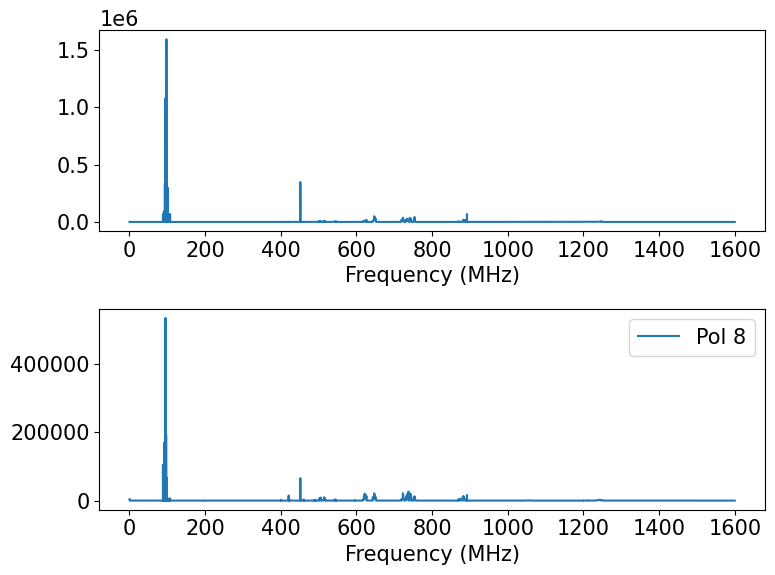

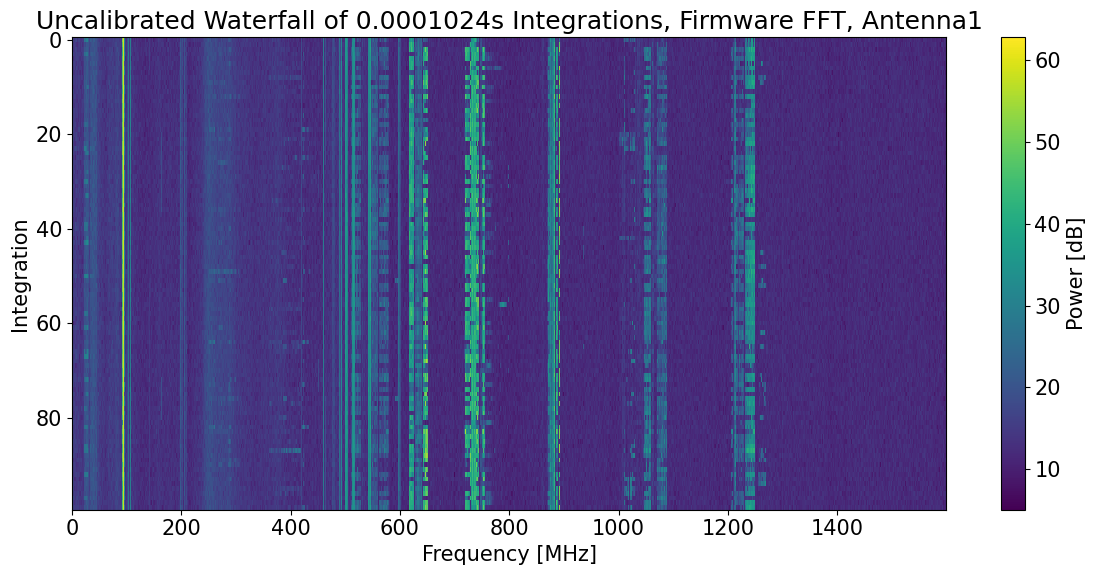

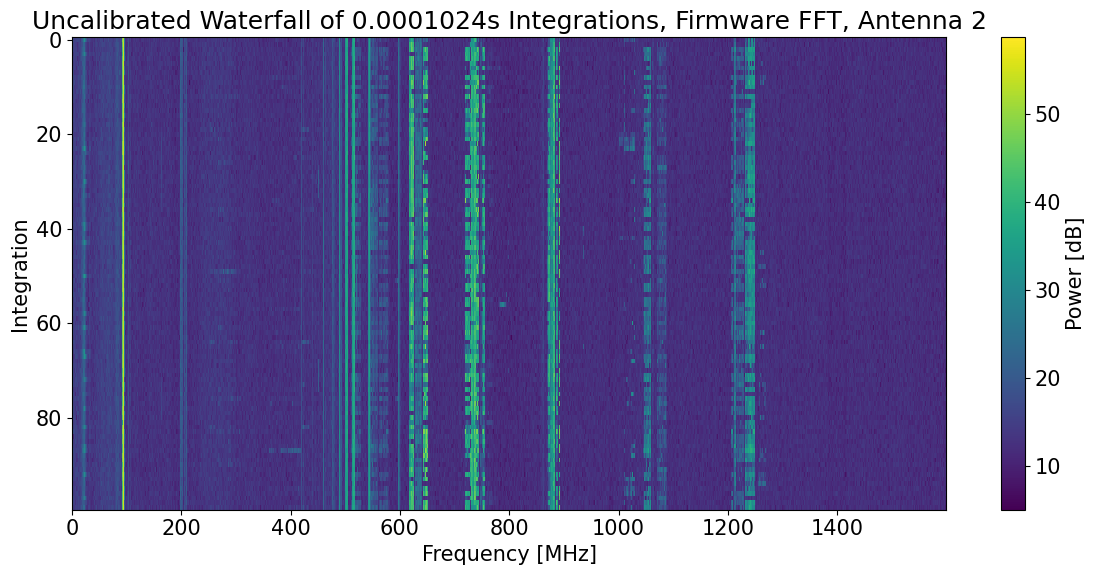

In [27]:
fig, ax = plt.subplots(2, figsize = (8, 6))
ax[0].plot(ccc.f, np.mean(psd_fft[:, 6],axis=0), label = f'Pol {7}')
ax[1].plot(ccc.f, np.mean(psd_fft[:, 7],axis=0), label = f'Pol {8}')
ax[0].set_xlabel('Frequency (MHz)')
ax[1].set_xlabel('Frequency (MHz)')
plt.legend()
plt.tight_layout()

# Zoom in on a given input
pol = 6

plt.figure(figsize = (12, 6))
plt.title(f'Uncalibrated Waterfall of {fft_integration_period}s Integrations, Firmware FFT, {board_inputs[pol]}')
plt.pcolormesh(ccc.f, np.arange(n_fft_integrations), 10*np.log10(psd_fft[:, pol, :]))
plt.colorbar(label = 'Power [dB]')
# plt.xlim(700, 725)
plt.ylabel('Integration')
plt.xlabel('Frequency [MHz]')
plt.gca().invert_yaxis()
plt.tight_layout()

# Zoom in on a given input
pol = 7

plt.figure(figsize = (12, 6))
plt.title(f'Uncalibrated Waterfall of {fft_integration_period}s Integrations, Firmware FFT, {board_inputs[pol]}')
plt.pcolormesh(ccc.f, np.arange(n_fft_integrations), 10*np.log10(psd_fft[:, pol, :]))
plt.colorbar(label = 'Power [dB]')
# plt.xlim(700, 725)
plt.ylabel('Integration')
plt.xlabel('Frequency [MHz]')
plt.gca().invert_yaxis()
plt.tight_layout()

## Move Pol 6 vertically

In [28]:
%%capture

psd_fft = np.zeros((n_fft_integrations, ccc.NPOLS, len(ccc.f)))
kert_fft = np.zeros((n_fft_integrations, ccc.NPOLS, len(ccc.f)))
fft_cap_adc_ovflws = np.zeros((n_fft_integrations, ccc.NPOLS))
# fft_cap_adc_rms_power_dBm = np.zeros((n_adc_integrations, ccc.NPOLS))
fft_cap_fft_ovflws = np.zeros((n_fft_integrations, ccc.NPOLS))

for n in range(n_fft_integrations):
    print(f'{n}/{n_fft_integrations}')
    
    # Pulse the overflows resets
    for m in range(ccc.NPOLS):

        # Reset ADC stats capture (which is actually in the Scaler module)
        ccc.i.chan[m].SCALER.STATS_FRAME_COUNT = n_fft_captures
        ccc.i.chan[m].SCALER.STATS_CAPTURE = 0 # capture new stats
        # print(m, ccc.i.chan[m].SCALER.STATS_CAPTURE)
        ccc.i.chan[m].SCALER.STATS_CAPTURE = 1
        # print(m, ccc.i.chan[m].SCALER.STATS_CAPTURE)

        # Reset FFT overflow counter
        ccc.i.chan[m].FFT.OVERFLOW_RESET = 1 
        ccc.i.chan[m].FFT.OVERFLOW_RESET = 0

    # Capture data
    d_fft = ccc.read_fft_frames(ncap = n_fft_captures, verbose=0)
    psd_fft[n] = np.mean(np.abs(d_fft)**2, axis = 1)
    kert_fft[n] = np.mean(np.abs(d_fft)**4, axis = 1)

    # Measure ADC overflows
    for m in range(ccc.NPOLS):
        # print(m, ccc.i.chan[m].SCALER.STATS_CAPTURE)
        # print(ccc.i.chan[m].SCALER.STATS_READY)
        ctr = 0
        while True:
            if ccc.i.chan[m].SCALER.STATS_READY == 1:
                fft_cap_adc_ovflws[n, m] = ccc.i.chan[m].SCALER.STATS_ADC_OVERFLOWS
                break
            else:
                ctr += 1
                
    # Measure FFT overflows
    fft_cap_fft_ovflws[n] = [ccc.i.chan[m].FFT.OVERFLOW_COUNT for m in range(ccc.NPOLS)]

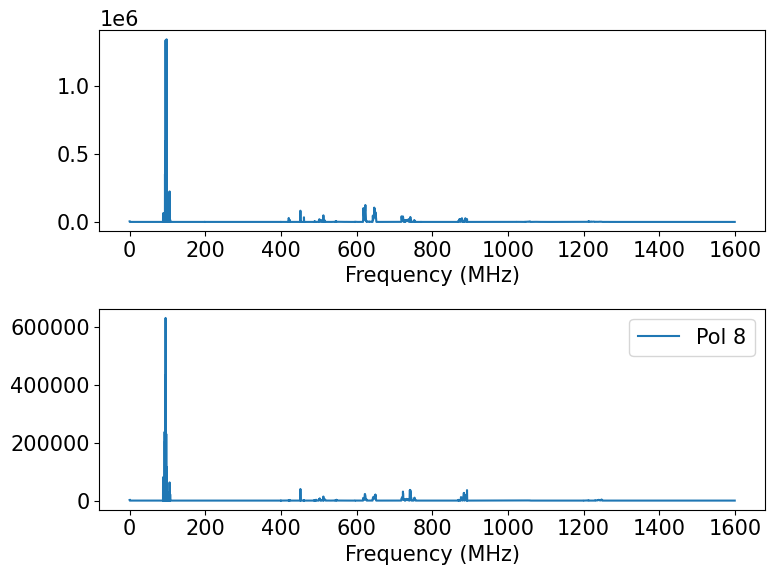

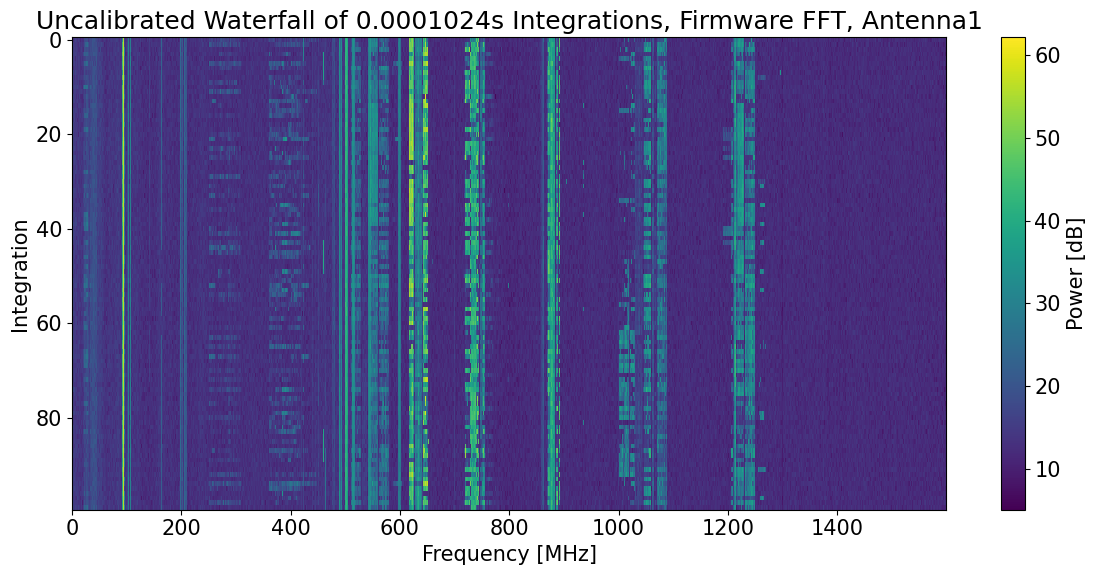

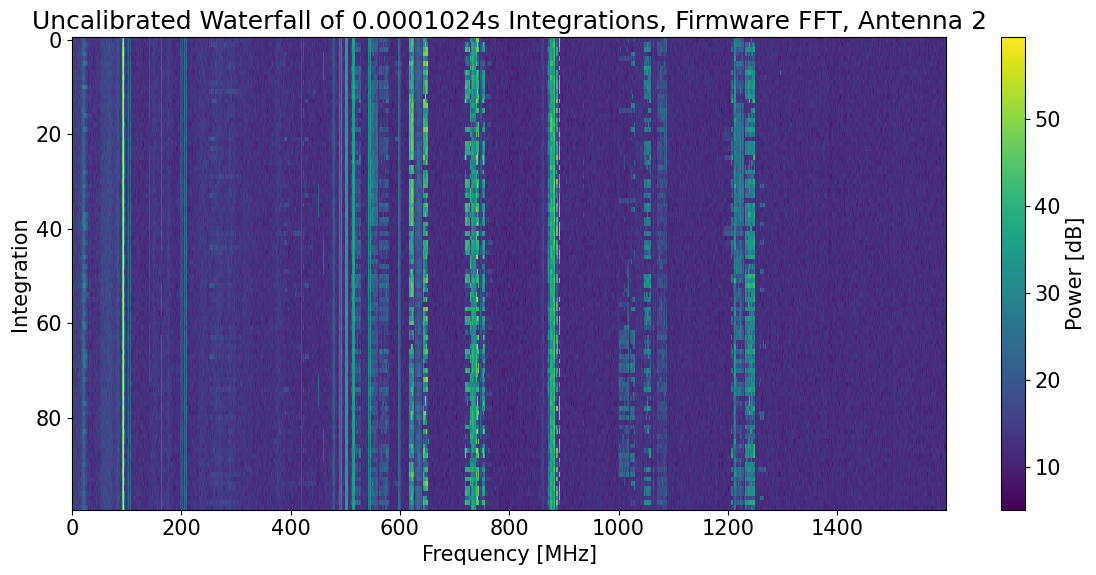

In [29]:
fig, ax = plt.subplots(2, figsize = (8, 6))
ax[0].plot(ccc.f, np.mean(psd_fft[:, 6],axis=0), label = f'Pol {7}')
ax[1].plot(ccc.f, np.mean(psd_fft[:, 7],axis=0), label = f'Pol {8}')
ax[0].set_xlabel('Frequency (MHz)')
ax[1].set_xlabel('Frequency (MHz)')
plt.legend()
plt.tight_layout()

# Zoom in on a given input
pol = 6

plt.figure(figsize = (12, 6))
plt.title(f'Uncalibrated Waterfall of {fft_integration_period}s Integrations, Firmware FFT, {board_inputs[pol]}')
plt.pcolormesh(ccc.f, np.arange(n_fft_integrations), 10*np.log10(psd_fft[:, pol, :]))
plt.colorbar(label = 'Power [dB]')
# plt.xlim(700, 725)
plt.ylabel('Integration')
plt.xlabel('Frequency [MHz]')
plt.gca().invert_yaxis()
plt.tight_layout()

# Zoom in on a given input
pol = 7

plt.figure(figsize = (12, 6))
plt.title(f'Uncalibrated Waterfall of {fft_integration_period}s Integrations, Firmware FFT, {board_inputs[pol]}')
plt.pcolormesh(ccc.f, np.arange(n_fft_integrations), 10*np.log10(psd_fft[:, pol, :]))
plt.colorbar(label = 'Power [dB]')
# plt.xlim(700, 725)
plt.ylabel('Integration')
plt.xlabel('Frequency [MHz]')
plt.gca().invert_yaxis()
plt.tight_layout()

## Rotate both 90 degrees

In [33]:
%%capture

psd_fft = np.zeros((n_fft_integrations, ccc.NPOLS, len(ccc.f)))
kert_fft = np.zeros((n_fft_integrations, ccc.NPOLS, len(ccc.f)))
fft_cap_adc_ovflws = np.zeros((n_fft_integrations, ccc.NPOLS))
# fft_cap_adc_rms_power_dBm = np.zeros((n_adc_integrations, ccc.NPOLS))
fft_cap_fft_ovflws = np.zeros((n_fft_integrations, ccc.NPOLS))

for n in range(n_fft_integrations):
    print(f'{n}/{n_fft_integrations}')
    
    # Pulse the overflows resets
    for m in range(ccc.NPOLS):

        # Reset ADC stats capture (which is actually in the Scaler module)
        ccc.i.chan[m].SCALER.STATS_FRAME_COUNT = n_fft_captures
        ccc.i.chan[m].SCALER.STATS_CAPTURE = 0 # capture new stats
        # print(m, ccc.i.chan[m].SCALER.STATS_CAPTURE)
        ccc.i.chan[m].SCALER.STATS_CAPTURE = 1
        # print(m, ccc.i.chan[m].SCALER.STATS_CAPTURE)

        # Reset FFT overflow counter
        ccc.i.chan[m].FFT.OVERFLOW_RESET = 1 
        ccc.i.chan[m].FFT.OVERFLOW_RESET = 0

    # Capture data
    d_fft = ccc.read_fft_frames(ncap = n_fft_captures, verbose=0)
    psd_fft[n] = np.mean(np.abs(d_fft)**2, axis = 1)
    kert_fft[n] = np.mean(np.abs(d_fft)**4, axis = 1)

    # Measure ADC overflows
    for m in range(ccc.NPOLS):
        # print(m, ccc.i.chan[m].SCALER.STATS_CAPTURE)
        # print(ccc.i.chan[m].SCALER.STATS_READY)
        ctr = 0
        while True:
            if ccc.i.chan[m].SCALER.STATS_READY == 1:
                fft_cap_adc_ovflws[n, m] = ccc.i.chan[m].SCALER.STATS_ADC_OVERFLOWS
                break
            else:
                ctr += 1
                
    # Measure FFT overflows
    fft_cap_fft_ovflws[n] = [ccc.i.chan[m].FFT.OVERFLOW_COUNT for m in range(ccc.NPOLS)]

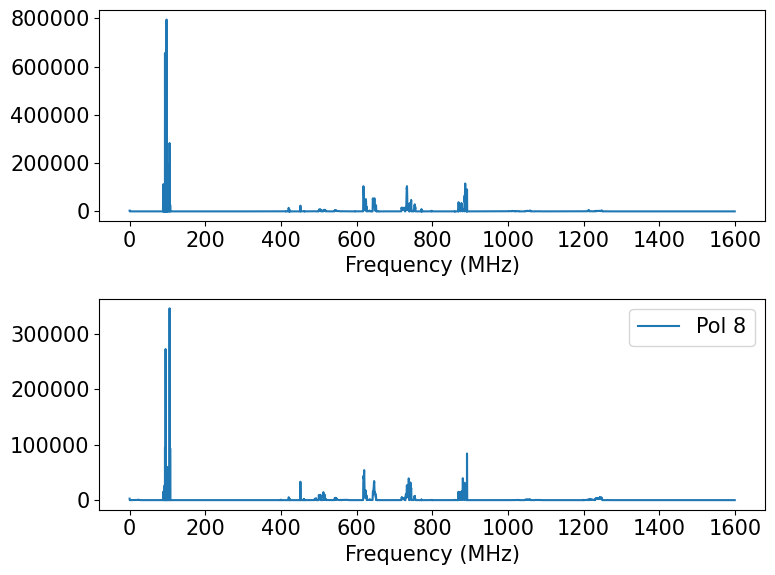

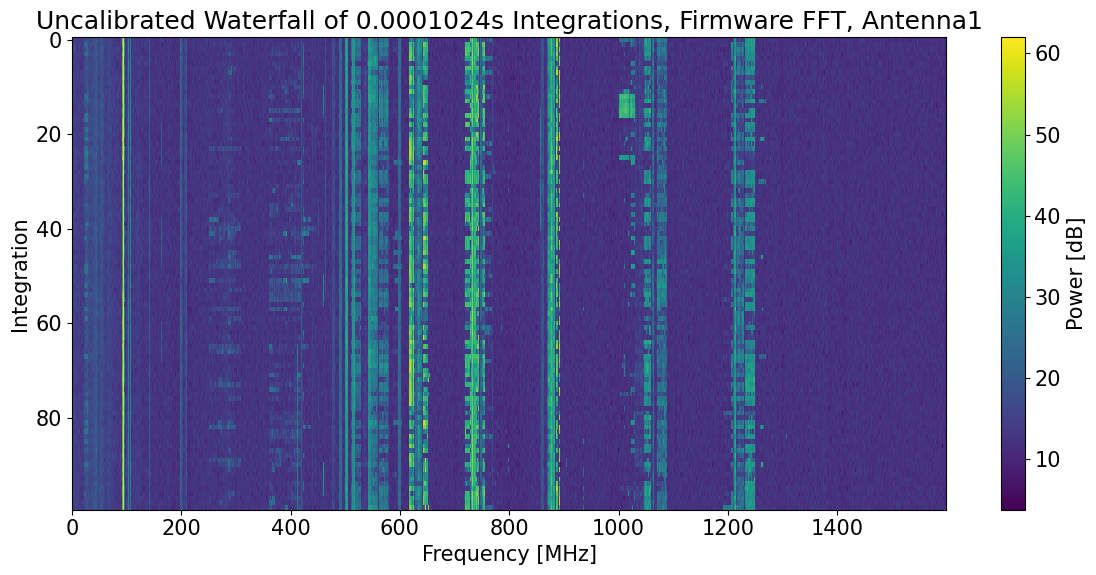

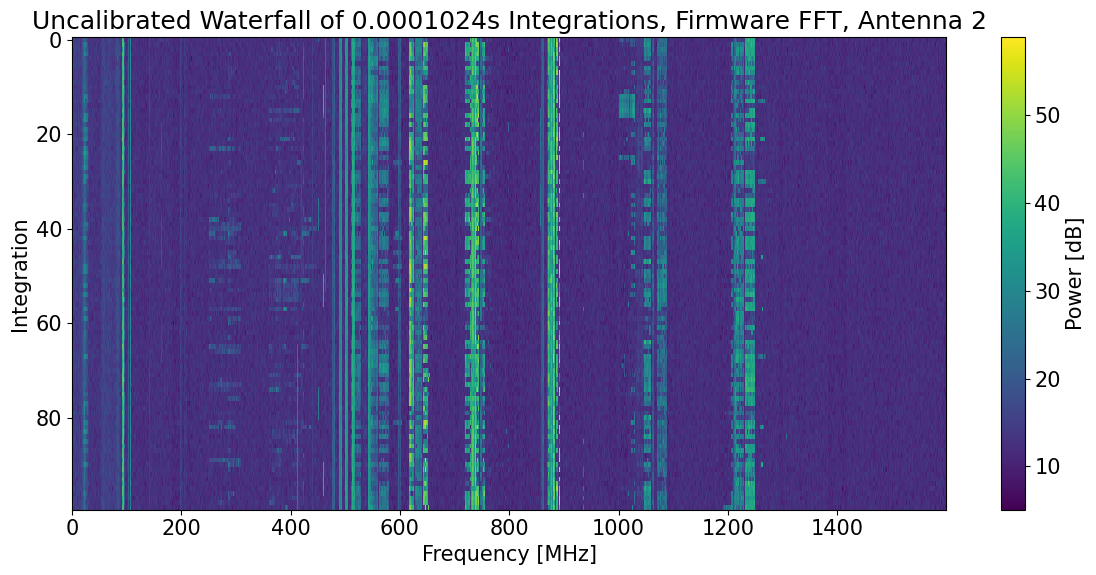

In [34]:
fig, ax = plt.subplots(2, figsize = (8, 6))
ax[0].plot(ccc.f, np.mean(psd_fft[:, 6],axis=0), label = f'Pol {7}')
ax[1].plot(ccc.f, np.mean(psd_fft[:, 7],axis=0), label = f'Pol {8}')
ax[0].set_xlabel('Frequency (MHz)')
ax[1].set_xlabel('Frequency (MHz)')
plt.legend()
plt.tight_layout()

# Zoom in on a given input
pol = 6

plt.figure(figsize = (12, 6))
plt.title(f'Uncalibrated Waterfall of {fft_integration_period}s Integrations, Firmware FFT, {board_inputs[pol]}')
plt.pcolormesh(ccc.f, np.arange(n_fft_integrations), 10*np.log10(psd_fft[:, pol, :]))
plt.colorbar(label = 'Power [dB]')
# plt.xlim(700, 725)
plt.ylabel('Integration')
plt.xlabel('Frequency [MHz]')
plt.gca().invert_yaxis()
plt.tight_layout()

# Zoom in on a given input
pol = 7

plt.figure(figsize = (12, 6))
plt.title(f'Uncalibrated Waterfall of {fft_integration_period}s Integrations, Firmware FFT, {board_inputs[pol]}')
plt.pcolormesh(ccc.f, np.arange(n_fft_integrations), 10*np.log10(psd_fft[:, pol, :]))
plt.colorbar(label = 'Power [dB]')
# plt.xlim(700, 725)
plt.ylabel('Integration')
plt.xlabel('Frequency [MHz]')
plt.gca().invert_yaxis()
plt.tight_layout()

### Zoom in on the repeater

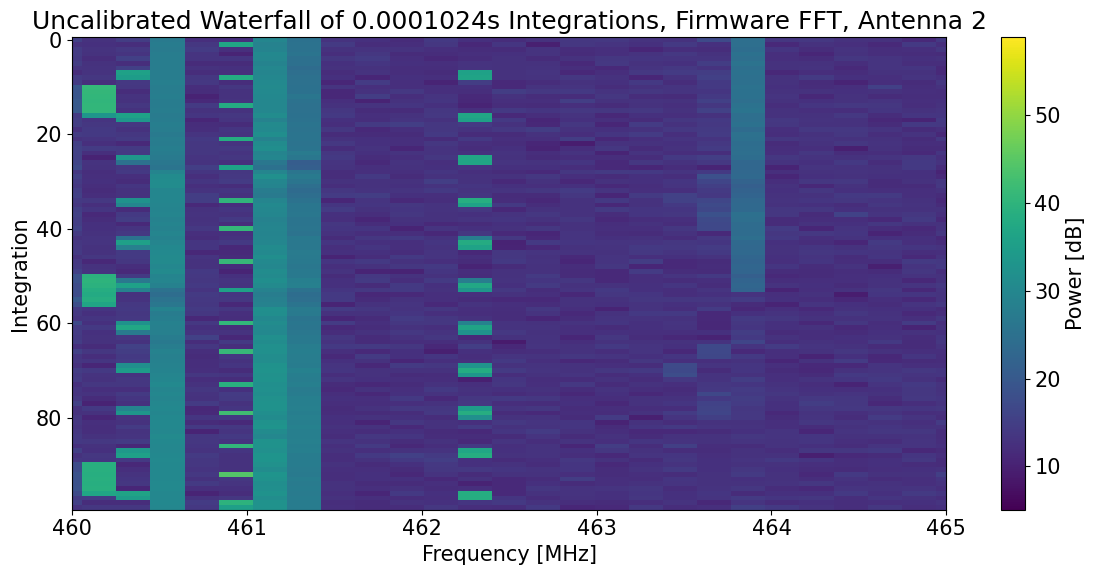

In [37]:
# Zoom in on a given input
pol = 7

plt.figure(figsize = (12, 6))
plt.title(f'Uncalibrated Waterfall of {fft_integration_period}s Integrations, Firmware FFT, {board_inputs[pol]}')
plt.pcolormesh(ccc.f, np.arange(n_fft_integrations), 10*np.log10(psd_fft[:, pol, :]))
plt.colorbar(label = 'Power [dB]')
plt.xlim(460, 465)
plt.ylabel('Integration')
plt.xlabel('Frequency [MHz]')
plt.gca().invert_yaxis()
plt.tight_layout()

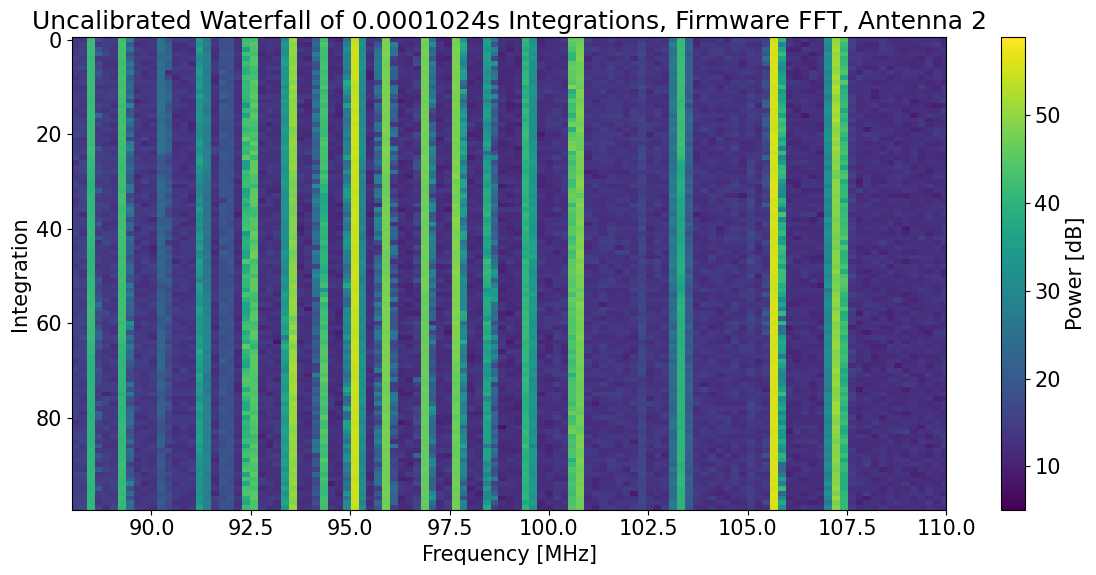

In [39]:
# Zoom in on a given input
pol = 7

plt.figure(figsize = (12, 6))
plt.title(f'Uncalibrated Waterfall of {fft_integration_period}s Integrations, Firmware FFT, {board_inputs[pol]}')
plt.pcolormesh(ccc.f, np.arange(n_fft_integrations), 10*np.log10(psd_fft[:, pol, :]))
plt.colorbar(label = 'Power [dB]')
plt.xlim(88, 110)
plt.ylabel('Integration')
plt.xlabel('Frequency [MHz]')
plt.gca().invert_yaxis()
plt.tight_layout()

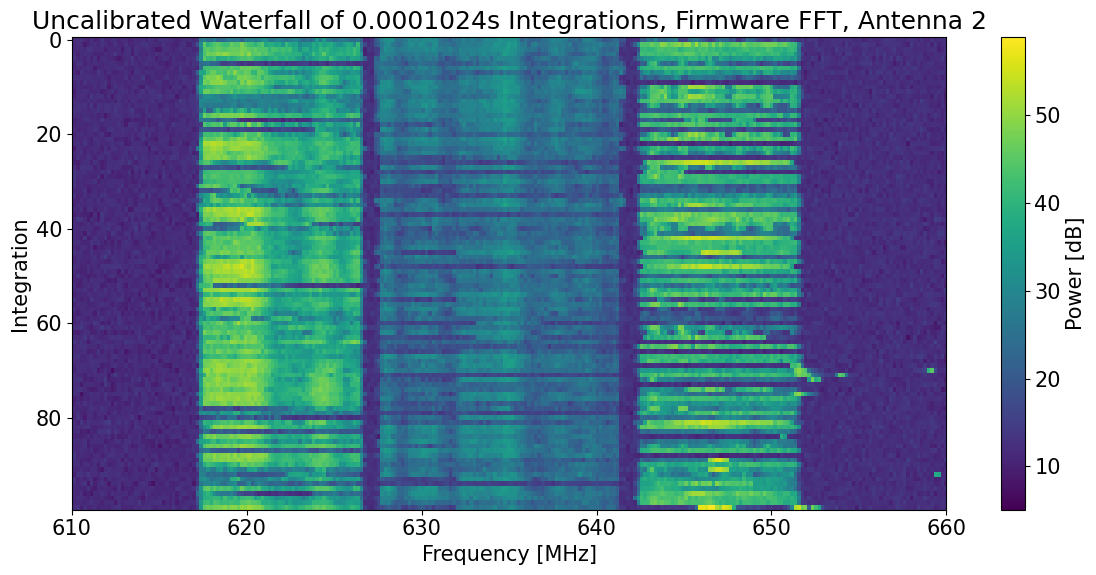

In [41]:
# Zoom in on a given input
pol = 7

plt.figure(figsize = (12, 6))
plt.title(f'Uncalibrated Waterfall of {fft_integration_period}s Integrations, Firmware FFT, {board_inputs[pol]}')
plt.pcolormesh(ccc.f, np.arange(n_fft_integrations), 10*np.log10(psd_fft[:, pol, :]))
plt.colorbar(label = 'Power [dB]')
plt.xlim(610, 660)
plt.ylabel('Integration')
plt.xlabel('Frequency [MHz]')
plt.gca().invert_yaxis()
plt.tight_layout()

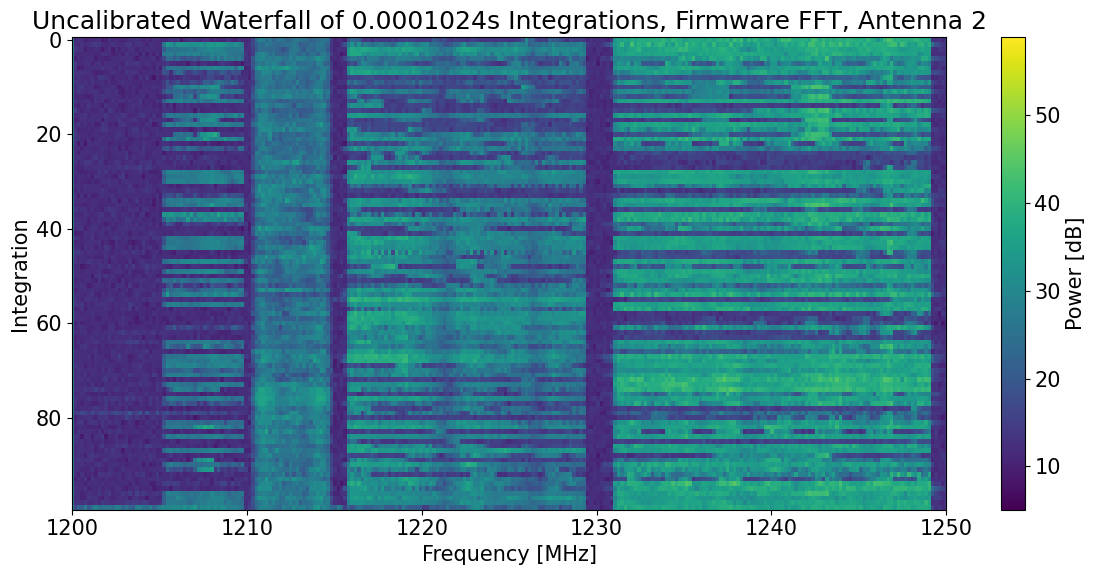

In [42]:
# Zoom in on a given input
pol = 7

plt.figure(figsize = (12, 6))
plt.title(f'Uncalibrated Waterfall of {fft_integration_period}s Integrations, Firmware FFT, {board_inputs[pol]}')
plt.pcolormesh(ccc.f, np.arange(n_fft_integrations), 10*np.log10(psd_fft[:, pol, :]))
plt.colorbar(label = 'Power [dB]')
plt.xlim(1200, 1250)
plt.ylabel('Integration')
plt.xlabel('Frequency [MHz]')
plt.gca().invert_yaxis()
plt.tight_layout()

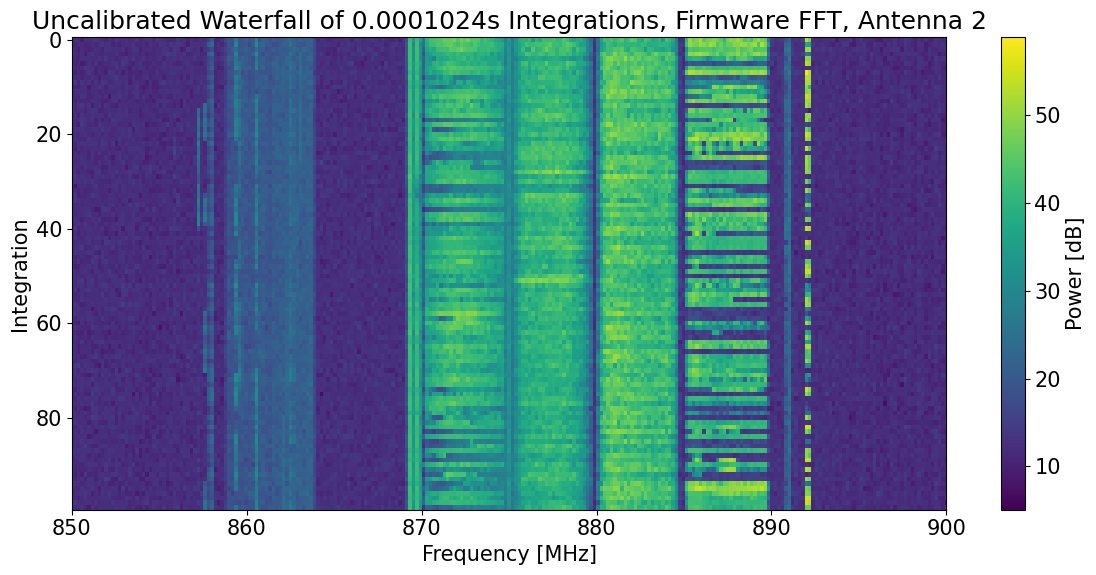

In [44]:
# Zoom in on a given input
pol = 7

plt.figure(figsize = (12, 6))
plt.title(f'Uncalibrated Waterfall of {fft_integration_period}s Integrations, Firmware FFT, {board_inputs[pol]}')
plt.pcolormesh(ccc.f, np.arange(n_fft_integrations), 10*np.log10(psd_fft[:, pol, :]))
plt.colorbar(label = 'Power [dB]')
plt.xlim(850, 900)
plt.ylabel('Integration')
plt.xlabel('Frequency [MHz]')
plt.gca().invert_yaxis()
plt.tight_layout()